# **Exercise 2: Time Series Forecasting**

## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

## Part I: Stationary Series
---
#### **Dataset:** `jeans_data_full_dataset`

Think back to the regression performed on the dataset for HW assignment 1, using 520 weeks of
jeans data for a medium-sized retailer in the southeast region. In that context, we estimated the
sales of fashion jeans based on the selling price and controlling for special events. Once we ran
the OLS regression, we also obtained residuals for the week-to-week sales.  

For this problem on stationary series, you will setup and execute two types of forecast methods,
using all residuals (not the sales variable, which was the original demand signal) as the training
sample. Note that there is no need for a test or holdout dataset to forecast for this problem.

### Loading the dataset

In [ ]:
jeans_data = pd.read_excel('/content/jeans_data_full_dataset.xlsx')
jeans_data.head()

,week,price,sales,special_event,se_indicator
0,1,94,259,New Year's Day,1
1,2,135,69,NaN,0
2,3,135,59,NaN,0
3,4,81,149,NaN,0
4,5,135,72,NaN,0


In [ ]:
jeans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   week           520 non-null    int64 
 1   price          520 non-null    int64 
 2   sales          520 non-null    int64 
 3   special_event  120 non-null    object
 4   se_indicator   520 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 20.4+ KB


In [ ]:
# OLS Regression of price and special event indicator on sales

X = sm.add_constant(jeans_data[['price','se_indicator']])
y = jeans_data['sales']

# Fitting the OLS Model
model = sm.OLS(y, X).fit()

# Results Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     3427.
Date:                Tue, 02 Apr 2024   Prob (F-statistic):          4.66e-299
Time:                        15:57:27   Log-Likelihood:                -2253.1
No. Observations:                 520   AIC:                             4512.
Df Residuals:                     517   BIC:                             4525.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          252.0725      7.902     31.901   

In [ ]:
# Getting the residuals from the above regression

jeans_data["residual"] = model.resid
jeans_data.head()

,week,price,sales,special_event,se_indicator,residual
0,1,94,259,New Year's Day,1,33.096706
1,2,135,69,NaN,0,-0.508483
2,3,135,59,NaN,0,-10.508483
3,4,81,149,NaN,0,6.465910
4,5,135,72,NaN,0,2.491517


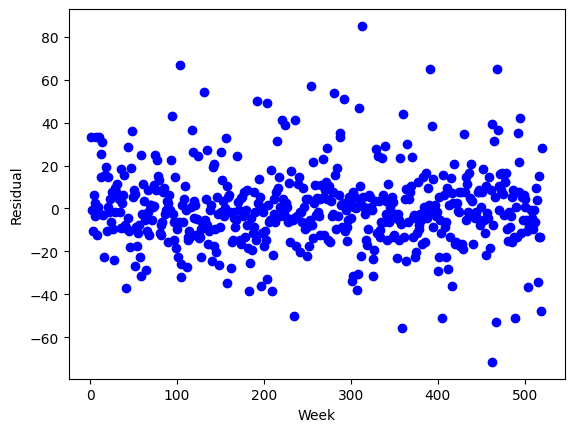

In [ ]:
# Checking if the "residual" is stationary

jeans_data = jeans_data.sort_values(by='week')

plt.scatter(x="week", y="residual", data = jeans_data, color = "blue")
plt.xlabel("Week")
plt.ylabel("Residual")
plt.show();

### a. Moving Average (MA) Estimations

- Try N = 1 to 5 and forecast estimates for weeks 6 to 520
- Start forecast on week 6 as need 5 weeks of historical data for N=5
- Report resultant MSE values  
- MA* = [MA(N) with optimal value of N]

In [ ]:
# Trying N = 1 to 5 and forecasting estimates for weeks 6 to 520

ma_mse = {}

for index in range(1,6):
    ma_mse[index] = mean_squared_error(jeans_data.residual[5:],
                                       jeans_data["residual"].rolling(index).mean()[4:519])

jeans_ma_mse = pd.DataFrame(list(ma_mse.items()), columns=['MA_window','MSE'])

jeans_ma_mse.sort_values(by='MSE').reset_index(drop=True)

,MA_window,MSE
0,5,401.831427
1,4,407.832961
2,3,443.505466
3,2,532.716218
4,1,704.900311


**Result**

The Moving Average method with N = 5 yields the lowest Mean Squared Error of 401.83. Therefore, the optimal approach for forecasting future values of this time series would be to use the Moving Average method with a window size of 5 periods. This window size strikes the best balance between smoothing out random fluctuations and capturing the underlying trend in the data, resulting in the most precise forecasts among the window sizes evaluated.

### b. Single Exponential Smoothing (ES) Estimations

- Try alpha = 0.1 to 1 using 0.1 increments and forecast estimates for weeks 6 to 520
- Assume a burn-in period of 5 weeks
- Report resultant MSE values  
- Single ES* = [Single ES(alpha) with optimal value of alpha]

In [ ]:
# Trying alpha = 0.1 to 1 and forecasting estimates for weeks 6 to 520

es_mse = {}

for alpha in np.arange(0.1, 1.1, 0.1):
    es_mse[alpha] = mean_squared_error(jeans_data.residual[5:],
                                       ExponentialSmoothing(jeans_data.residual, initialization_method='estimated').fit(smoothing_level = alpha).predict(5,519))

jeans_es_mse = pd.DataFrame(list(es_mse.items()), columns=['ES_alpha','MSE'])

jeans_es_mse.sort_values(by='MSE').reset_index(drop=True)

,ES_alpha,MSE
0,0.1,359.711838
1,0.2,379.988772
2,0.3,403.243310
3,0.4,430.380723
4,0.5,461.790534
5,0.6,497.866123
6,0.7,539.174129
7,0.8,586.536837
8,0.9,641.166635
9,1.0,704.900311


**Result**

The Single Exponential Smoothing method with a smoothing parameter alpha = 0.1 provided the most accurate forecasts, as it resulted in the lowest Mean Squared Error of 359.71 among the different alpha values tested. This suggests that when forecasting future values of this time series, using the Single Exponential Smoothing method with an alpha of 0.1 would be the preferred approach, as it minimizes the forecasting errors based on the provided Mean Squared Error metric.

### c. Assess Optimal MA v/s Single ES

- Generate plot with residuals, MA* forecast, and Single ES* forecast
- Compare MA* and Single ES* outcomes on training sample and provide your
recommendation of method and justification.

In [ ]:
# Forecasting weeks 6 to 520 using best MA window = 5
jeans_data.loc[5:,'MA'] = jeans_data.residual.rolling(5).mean()

# Forecasting weeks 6 to 520 using best SES alpha = 0.1
jeans_data.loc[5:,'SES'] = ExponentialSmoothing(jeans_data.residual, initialization_method='estimated').fit(smoothing_level = 0.1).predict(5,519)

In [ ]:
jeans_data.head(15)

,week,price,sales,special_event,se_indicator,residual,MA,SES
0,1,94,259,New Year's Day,1,33.096706,NaN,NaN
1,2,135,69,NaN,0,-0.508483,NaN,NaN
2,3,135,59,NaN,0,-10.508483,NaN,NaN
3,4,81,149,NaN,0,6.465910,NaN,NaN
4,5,135,72,NaN,0,2.491517,NaN,NaN
5,6,135,66,NaN,0,-3.508483,-1.113605,6.418486
6,7,94,259,Presidents' Day,1,33.096706,5.607433,5.425789
7,8,135,57,NaN,0,-12.508483,5.207433,8.192881
8,9,135,70,NaN,0,0.491517,4.012555,6.122744
9,10,101,149,NaN,0,33.512431,10.216737,5.559622


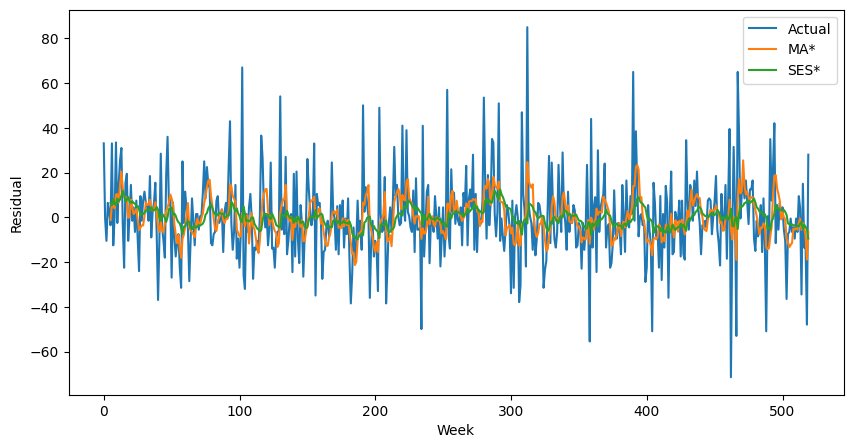

In [ ]:
# Plotting residuals, MA* forecast, and Single ES* forecast
plt.figure(figsize=(10,5))
plt.plot(jeans_data.residual, label='Actual')
plt.plot(jeans_data.MA[5:], label='MA*')
plt.plot(jeans_data.SES[5:], label='SES*')
plt.legend(loc='best')
plt.xlabel('Week')
plt.ylabel('Residual')
plt.show();

**Result**

The Single Exponential Smoothing forecast (alpha = 0.1) tracks actual data more closely, adapting better to trend shifts and level changes, while the Moving Average forecast (N = 5) is better at smoothing random noise but less responsive to changes. The preferred method depends on the data's characteristics - whether frequent trend shifts (favoring SES) or occasional random fluctuations (favoring MA) are more prominent. Optimal parameter selection for window size (MA) and smoothing factor (SES) is crucial for accurate forecasts based on the dataset.

## Part II: Non-Stationary Series with Trend
---
#### **Dataset:** `bitcoin_data`

You are hired as a consultant to apply your forecasting skills for predicting future outcomes of
Bitcoin prices. You are given historical Bitcoin data for a range of interest. The data consists of
the Bitcoin closing price from March 2023 – March 2024.

### Loading the dataset

In [ ]:
bitcoin_data = pd.read_excel('/content/bitcoin_data.xlsx')
bitcoin_data.head()

,date,close_price
0,2023-03-22,27307.437500
1,2023-03-23,28333.972656
2,2023-03-24,27493.285156
3,2023-03-25,27494.707031
4,2023-03-26,27994.330078


In [ ]:
bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         366 non-null    datetime64[ns]
 1   close_price  366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


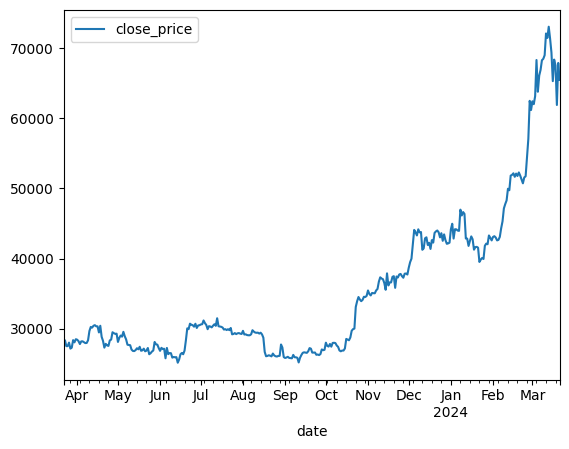

In [ ]:
# Eyeball test

bitcoin_data.plot.line(x="date", y="close_price");

### a. Test for Non-stationarity

- Using the Augmented Dickey-Fuller test, provide your conclusion on the nature of the data based on patterns of the Bitcoin prices over time.

In [ ]:
adf_result = adfuller(bitcoin_data.close_price)
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

ADF Statistic: 1.152174
p-value: 0.995638


**Result**

Given that the p-value is greater than 0.05, we fail to reject the null hypothesis of the presence of a unit root in the time series data. This suggests that the data may be non-stationary, indicating the potential presence of a trend or unit root in the dataset.

### b. Double Exponential Smoothing (DES) Estimations

- Provided that your test for non-stationarity was supported, forecast estimates by fitting a DES model  
- Try alpha and beta from 0 to 1 with 0.05 increments
- Use the first 266 days as training sample
- Assume a burn-in period of 10 days
- Calculate training sample MSE for days 11 to 266
- Forecast for the last 100 days
- DES* = [optimal DES(alpha,beta) with optimal combination of alpha and beta]
- Report resultant MSE values, both for process of forecasting training and test data. Provide a conclusion on whether the DES* performs better on the train or test data.
- Generate plot with Bitcoin prices and DES* forecasts. Explain what is represented in the plot.

In [ ]:
# Splitting bitcoin_data into train and test samples

bitcoin_train = bitcoin_data[:266]
bitcoin_test = bitcoin_data[266:]

In [ ]:
# Function that takes alpha and beta as input and produces the traning sample MSE
def DESMSE(alpha,beta):
    return mean_squared_error(bitcoin_data.close_price[10:266],
                              ExponentialSmoothing(bitcoin_data.close_price[:266], trend="add", initialization_method='estimated').fit(smoothing_level=alpha, smoothing_trend=beta).predict(10,265))

# Function that allows you to construct a dataframe of alpha-beta combinations
def expand_grid(dictionary):
    return pd.DataFrame([row for row in product(*dictionary.values())],
                       columns=dictionary.keys())

# Defining the alpha and beta values to try as a dictionary
dictionary = {'alpha': np.arange(0.0, 1.05, 0.05),
              'beta': np.arange(0.0, 1.05, 0.05)}

# Constructing alpha, beta values to try
des_results = expand_grid(dictionary)

# Adding a column called MSE, as a place holder for putting in the MSE results later
des_results["MSE"] = np.repeat(0,len(des_results))

In [ ]:
# Calculating MSE for all combinations of alpha-beta

for alpha in np.arange(0.0, 1.05, 0.05):
    for beta in np.arange(0.0, 1.05, 0.05):
        des_results.loc[(des_results["alpha"] == alpha) & (des_results["beta"] == beta), "MSE"] = DESMSE(alpha, beta)

In [ ]:
# Finding the best alpha-beta values

des_results.sort_values("MSE").head(10)

,alpha,beta,MSE
399,0.95,0.00,401731.203935
420,1.00,0.00,402518.535038
378,0.90,0.00,403372.561339
357,0.85,0.00,407553.055980
400,0.95,0.05,408445.511031
379,0.90,0.05,408781.472825
421,1.00,0.05,410673.072142
358,0.85,0.05,411753.556616
336,0.80,0.00,414467.130448
380,0.90,0.10,417358.672399


**Result**

For this particular time series dataset, applying the Double Exponential Smoothing method with a smoothing parameter alpha = 0.95 for the level component, and a smoothing parameter beta = 0.00 for the trend component, resulted in the most accurate forecasts overall.

The low value of beta (0.00) suggests that there is no significant trend present in the data, and the method is relying mainly on the level component smoothed with a high alpha value of 0.95 to generate forecasts.

The MSE of 401731.2 is the lowest obtained among the different combinations of alpha and beta values tested, indicating that these specific parameter values provide the best fit between the forecasted and actual values for this dataset when using the Double Exponential Smoothing approach.

In [ ]:
# Storing DES(0.95, 0.00) in the test sample

bitcoin_data.loc[bitcoin_data.index[266:],'DES'] = ExponentialSmoothing(bitcoin_data.close_price[:266],
                                                                        trend="add",
                                                                        initialization_method='estimated').fit(smoothing_level=0.95,
                                                                                                               smoothing_trend=0.00).forecast(100)
bitcoin_data

,date,close_price,DES
0,2023-03-22,27307.437500,NaN
1,2023-03-23,28333.972656,NaN
2,2023-03-24,27493.285156,NaN
3,2023-03-25,27494.707031,NaN
4,2023-03-26,27994.330078,NaN
...,...,...,...
361,2024-03-17,68390.625000,46555.087448
362,2024-03-18,67548.593750,46608.275464
363,2024-03-19,61912.773438,46661.463480
364,2024-03-20,67913.671875,46714.651496


In [ ]:
# MSE when forecasting on Train and Test samples

print('Train data MSE:', des_results.loc[399,'MSE'])
print('Test data MSE:', mean_squared_error(bitcoin_data.close_price[266:], bitcoin_data.DES[266:]))

Train data MSE: 401731.203935149
Test data MSE: 110489740.33291502


**Result**

For the training data, the Double Exponential Smoothing method (DES*) achieved an MSE of 401731.203935149. However, when applied to the test data, the MSE increased substantially to 110489740.33291502.

This significant increase in the MSE for the test data compared to the training data suggests that the Double Exponential Smoothing method did not generalize well to the unseen test data and possibly indicates overfitting in the train sample.

In other words, while the DES* model performed reasonably well on the training data it was fitted on, it failed to capture the underlying patterns in the test data accurately, leading to much higher forecasting errors.

Therefore, based on the reported MSE values, we can conclude that the Double Exponential Smoothing method performs better on the training data than on the test data for this particular dataset.

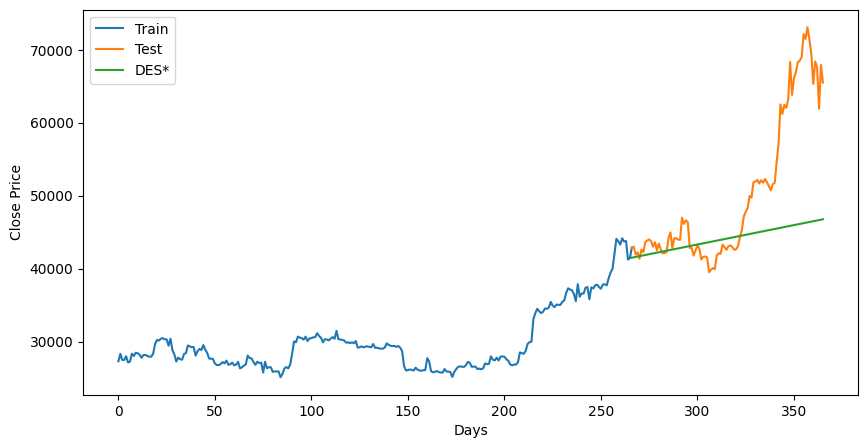

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(bitcoin_data.close_price[:267], label='Train')
plt.plot(bitcoin_data.close_price[266:], label='Test')
plt.plot(bitcoin_data.DES[266:], label='DES*')
plt.legend(loc='best')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.show();

**Result**

The graph displays the historical Bitcoin prices in blue, which form the training set used to develop the Double Exponential Smoothing (DES) forecasting model. This training data allows the model to learn and capture the overall trend present in the price movements. The subsequent orange line represents the test set, consisting of real-world, unseen data that serves as a benchmark to evaluate the model's predictive performance on new observations.

The green line illustrates the DES model's forecasted Bitcoin prices, extending into the future based on the patterns learned from the training set. This forecast demonstrates the model's attempt to predict future price movements by extrapolating the trends observed in the historical data.

Upon visual inspection, it can be seen that while the DES forecast broadly follows the general trend exhibited in the training set, it fails to accurately capture the more extreme fluctuations and volatility present in the test set data. Notably, the model struggles to predict the sharp upward price movement observed towards the latter part of the test set period.

In summary, while the DES model successfully captures the overall trend in the training data, its forecasting abilities are limited in accurately predicting the more substantial price swings and abrupt changes witnessed in the unseen test set, particularly the significant upward spike in Bitcoin prices.